<a href="https://colab.research.google.com/github/Valerie-Fan/gtzan-audio-classification/blob/main/GTZAN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I. Introduction

## Required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

# Librosa (for processing audio file)
import librosa
import librosa.display
import IPython.display as ipd

# deep/machine learning essentials
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf

# torch audio
import torchaudio
import torchaudio.transforms as T

# Part II. Understanding the Dataset

In [ ]:
# import the dataset from kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 98% 1.19G/1.21G [00:06<00:00, 213MB/s]
100% 1.21G/1.21G [00:06<00:00, 189MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gtzan-dataset-music-genre-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# dealing with corrupted file jazz.00054.wav
!rm -f /content/Data/genres_original/jazz/jazz.00054.wav
!cp /content/Data/genres_original/jazz/jazz.00053.wav /content/Data/genres_original/jazz/jazz.00054.wav


## Exploring auido files

There are 10 genres in this dataset

In [ ]:
general_path = '/content/Data/genres_original'
classes = list(os.listdir(f'{general_path}'))
classes

['country',
 'hiphop',
 'rock',
 'jazz',
 'metal',
 'disco',
 'blues',
 'pop',
 'classical',
 'reggae']

Now we are taking audio file 'classical.00008.wav' as an example to illustrate the general form of audio files and how we process tham.
Audio files could be loaded by Librosa to **samples** and **sample rate**:
*   **Samples** (y): the intensity or amplitude of the wave at each sample
*   **Sample rate** (sr): the number of samples of audio carried per second, measured in Hz or kHz






In [ ]:
audio_path = '/content/Data/genres_original/classical/classical.00008.wav'
y, sr = librosa.load(audio_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sr, '\n')

# length of the audio
print('Audio length (sec):', len(y)/sr)

y: [0.01538086 0.02087402 0.01119995 ... 0.06060791 0.06332397 0.03695679] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Audio length (sec): 30.013333333333332


We could use Ipython.display to play the audio.

In [ ]:
ipd.Audio(audio_path)

Also, librosa provide a library to plot the sound waves of audio.

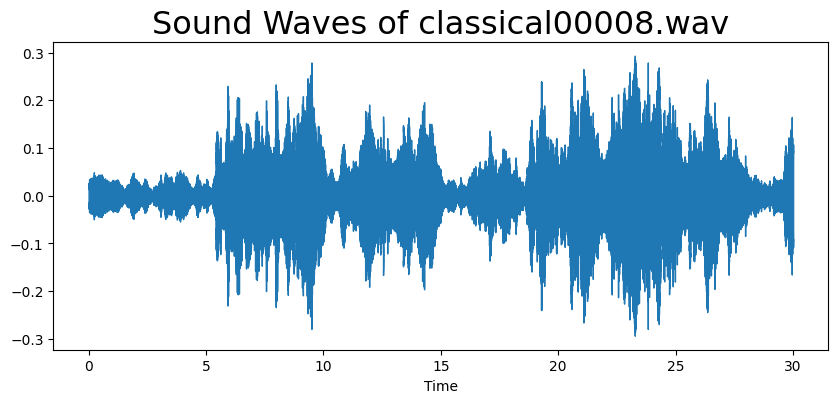

In [ ]:
plt.figure(figsize = (10, 4))
librosa.display.waveshow(y, sr = sr)
plt.title("Sound Waves of classical00008.wav", fontsize = 23);

However, only loading amplitude and sample rate of the audio does not provide much information. For example, we do not understanding the intensities of frequencies of each sample. That is why we are now introducing **Fourier Transform**.

### Fourier Transform

Fourier Transform is a audio data processing method which decomposes the signal into its constituent frequencies and displays the amplitude of each frequency present in the signal. <br>


*   x-axis: time (0-30 secs)
*   y-axis: frequencies
*   colors: represents the intensity of the given frequencies at a given time






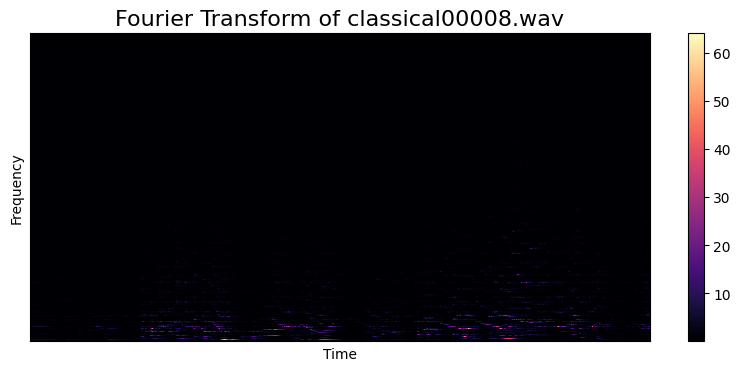

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between stft columns

plt.figure(figsize = (10, 4))
sgram = librosa.stft(y)
stft = np.abs(sgram)
librosa.display.specshow(sgram,n_fft = n_fft, hop_length = hop_length)
plt.title("Fourier Transform of classical00008.wav", fontsize = 16);
plt.colorbar();
plt.xlabel("Time");
plt.ylabel("Frequency");

But why can't we recognize the differences of the frequencies? It is because human are more sensitive to differences between lower frequencies than higher frequencies. Also, we are more sensitive to differences between lower amplitude than higher amplitude. So we have to implement **Mel Scale** and **Decibel Scale** in the transform.





### Mel scaling and Decibel scaling
*   **Mel Scale** processes the frequencies of the sound logarithmically rather than linearly.
*   **Decibel Scale** is similar to Mel Scale, it processes the loudness of the sound logarithmically.

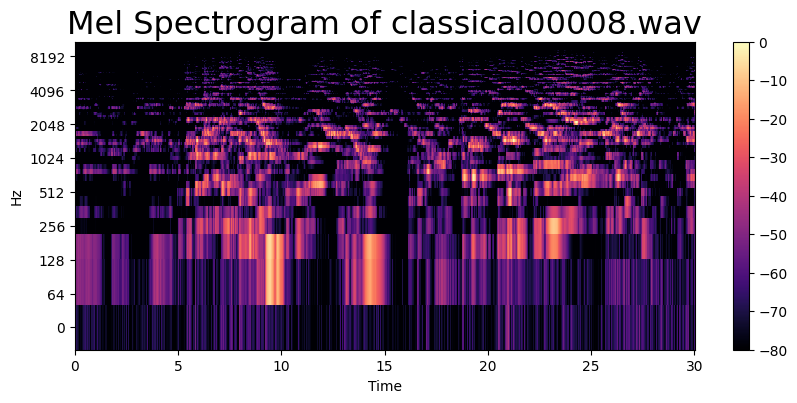

In [ ]:
y, _ = librosa.effects.trim(y)

mel_scale = librosa.feature.melspectrogram(y = y, sr = sr, n_fft = n_fft, hop_length = hop_length)
decibel_scale = librosa.amplitude_to_db(mel_scale, ref=np.max)
plt.figure(figsize = (10, 4))
librosa.display.specshow(decibel_scale, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log');
plt.colorbar();
plt.title("Mel Spectrogram of classical00008.wav", fontsize = 23);

### MFCC (for Human Speech)

Mel Spectrograms work well for most audio deep learning applications. However, for problems dealing with human speech, MFCC (Mel Frequency Cepstral Coefficients) sometimes work better.

It essentially take Mel Spectrograms and apply a couple of further processing steps. This selects a compressed representation of the frequency bands from the Mel Spectrogram that correspond to the most common frequencies at which humans speak.

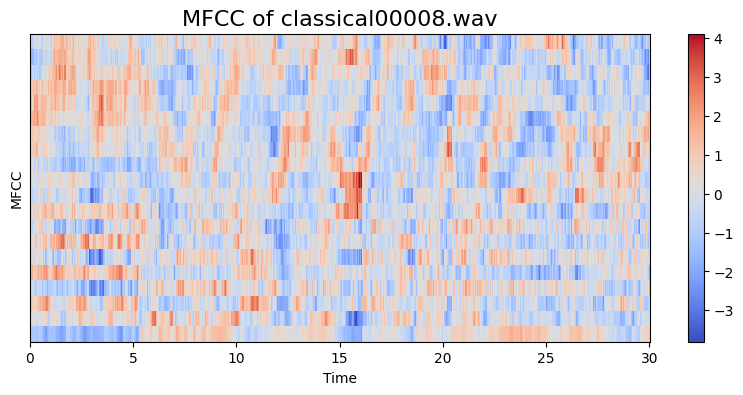

In [ ]:
mfcc = librosa.feature.mfcc(y = y, sr = sr, n_fft = n_fft, hop_length = hop_length)

# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
plt.figure(figsize = (10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.xlabel("Time");
plt.ylabel("MFCC");
plt.colorbar();
plt.title("MFCC of classical00008.wav", fontsize = 16);


Now we've understood how to process audio. In part 3, we will be using this concept to generate spectrograms to perform audio classification with CNN.

## Exploring the Metadata (features files)

In this section, we will be exploring feature_30_sec.csv. We will not use data in this file to perform CNN; however, this data includes important information - path of the audio files and the label of each wav. file. We will use this information to create a metadata table, this way we could load the audio file according to this table.

This file contains the mean and variance of audio features such as mel-scaled data, MFCC, and chroma features, etc. For simplicity, we will not explain each feature exhaustively, but perform EDA by  visualizing with corelation computation, and dimension-reduction with **PCA** and **t-SNE**.

### Creating a Metadata Table

First, we would like to scan the feature file to create a metadata table, this table will contain 2 columns:


*   The relative path of the audio file
*   The label (genre) of the audio



In [ ]:
# import the feature dataset
df = pd.read_csv('/content/Data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
relative_path = '/content/Data/genres_original/' + df['label'] + '/' + df['filename']
label = df['label']

metadata = pd.DataFrame({'relative_path': relative_path, 'label': label})
metadata.head()

,relative_path,label
0,/content/Data/genres_original/blues/blues.0000...,blues
1,/content/Data/genres_original/blues/blues.0000...,blues
2,/content/Data/genres_original/blues/blues.0000...,blues
3,/content/Data/genres_original/blues/blues.0000...,blues
4,/content/Data/genres_original/blues/blues.0000...,blues


In [ ]:
# encoding labels
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['label'])
metadata.head()

,relative_path,label
0,/content/Data/genres_original/blues/blues.0000...,0
1,/content/Data/genres_original/blues/blues.0000...,0
2,/content/Data/genres_original/blues/blues.0000...,0
3,/content/Data/genres_original/blues/blues.0000...,0
4,/content/Data/genres_original/blues/blues.0000...,0


In [ ]:
metadata['label'].value_counts()

label
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: count, dtype: int64

### EDA

The second task we would perform based on feature dataset is explorational data analysis (EDA).

In [ ]:
X = df.drop(['filename', 'length', 'label'], axis=1)
y = df['label']

<Axes: >

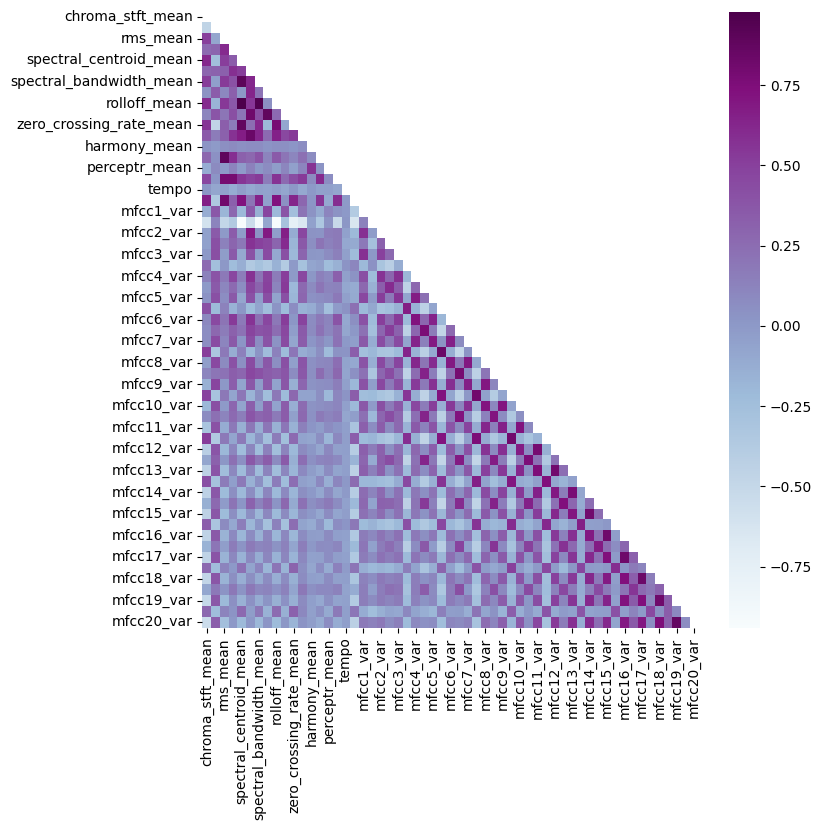

In [ ]:
# corelation matrix
corr = X.corr()
#Creation of a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, cmap="BuPu")

In [ ]:
# performing dimension-reduction by PCA and t-SNE for visualization

# normalizing
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# PCA and t-SNE
pca = PCA(n_components=10)
pca_result = pca.fit_transform(X)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

principalDf = pd.DataFrame(data = tsne_result, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.277253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.238266
[t-SNE] KL divergence after 300 iterations: 1.059087


array([0.24644968, 0.22028192, 0.09803759, 0.06511522, 0.05346794,
       0.03835612, 0.0272697 , 0.02215971, 0.02132351, 0.01650387])

Text(0, 0.5, 'Principal Component 2')

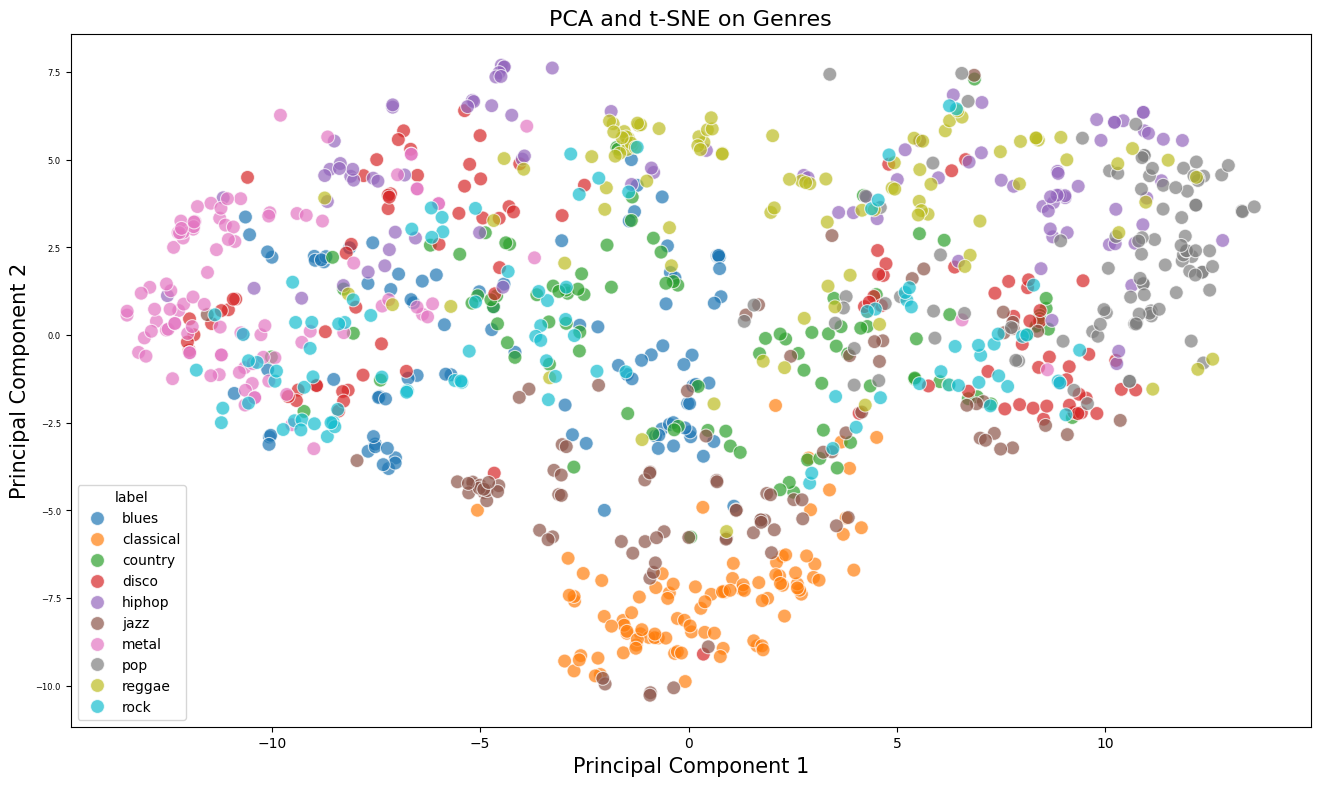

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA and t-SNE on Genres', fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 6);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

# Part III. Classification with CNN

## Audio Pre-processing

This training data with audio file paths cannot be input directly into the model. We have to load the audio data from the file and process it so that it is in a format that the model expects.

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  # ----------------------------
  # Standardize sampling rate
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a MFCC Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    # Convert the signal to spectrogram
    spec = transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB()(spec)
    return (spec)

  # ----------------------------
  # Augmentation
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec


## Define Custom Data Loader

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df):
    self.df = df
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)

  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # the relative path
    audio_file = self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'label']

    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=2048, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

## Prepare Batches of Data with the Data Loader

In [ ]:
from torch.utils.data import random_split

myds = SoundDS(metadata)

# Random split training, validation and testing sets
num_items = len(myds)
num_train = round(num_items * 0.7)
num_val = round(num_items * 0.15)
num_test = round(num_items * 0.15)
torch.manual_seed(42)
train_ds, val_ds, test_ds = random_split(myds, [num_train, num_val, num_test])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)

## Create a CNN Model

In [ ]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]
        self.dropout = nn.Dropout(p=0.3)

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]
        self.dropout = nn.Dropout(p=0.3)

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]
        self.dropout = nn.Dropout(p=0.3)

        # Forth Convolution Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]
        self.dropout = nn.Dropout(p=0.3)


        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [ ]:
# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

## Training

In [ ]:
from tqdm import tqdm  # Import tqdm for the progress bar functionality

def training(model, train_dl, val_dl, num_epochs, early_stopping_patience=20):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    best_val_loss = float('inf')
    epochs_no_improve = 0  # Track epochs with no improvement

    # Repeat for each epoch
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Training phase
        progress_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for i, data in progress_bar:
            inputs, labels = data[0], data[1]
            if isinstance(labels, tuple):  # Adjust based on your data structure
                labels = labels[0]
            inputs, labels = inputs.to(device), labels.to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            progress_bar.set_postfix({'loss': loss.item()})

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            for data in val_dl:
                inputs, labels = data[0], data[1]
                if isinstance(labels, tuple):
                    labels = labels[0]
                inputs, labels = inputs.to(device), labels.to(device)

                # Normalize the inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, prediction = torch.max(outputs, 1)
                val_correct += (prediction == labels).sum().item()
                val_total += prediction.shape[0]

            val_loss /= len(val_dl)
            val_accuracy = val_correct / val_total

        # Print training and validation stats
        avg_loss = running_loss / len(train_dl)
        acc = correct_prediction / total_prediction
        print(f'Epoch: {epoch+1}, Train Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}, Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered")
                break

    print('Finished Training')

In [ ]:
num_epochs = 200
training(myModel, train_dl, val_dl, num_epochs=num_epochs)

Epoch: 1, Train Loss: 2.33, Accuracy: 0.08, Val Loss: 2.33, Val Accuracy: 0.07


Epoch: 2, Train Loss: 2.32, Accuracy: 0.10, Val Loss: 2.32, Val Accuracy: 0.07


Epoch: 3, Train Loss: 2.32, Accuracy: 0.09, Val Loss: 2.31, Val Accuracy: 0.10


Epoch: 4, Train Loss: 2.30, Accuracy: 0.09, Val Loss: 2.30, Val Accuracy: 0.09


Epoch: 5, Train Loss: 2.30, Accuracy: 0.11, Val Loss: 2.29, Val Accuracy: 0.13


Epoch: 6, Train Loss: 2.28, Accuracy: 0.12, Val Loss: 2.30, Val Accuracy: 0.13


Epoch: 7, Train Loss: 2.26, Accuracy: 0.14, Val Loss: 2.26, Val Accuracy: 0.15


Epoch: 8, Train Loss: 2.25, Accuracy: 0.17, Val Loss: 2.26, Val Accuracy: 0.12


Epoch: 9, Train Loss: 2.24, Accuracy: 0.19, Val Loss: 2.24, Val Accuracy: 0.15


Epoch: 10, Train Loss: 2.21, Accuracy: 0.20, Val Loss: 2.23, Val Accuracy: 0.19


Epoch: 11, Train Loss: 2.20, Accuracy: 0.21, Val Loss: 2.22, Val Accuracy: 0.17


Epoch: 12, Train Loss: 2.18, Accuracy: 0.23, Val Loss: 2.18, Val Accuracy: 0.23


Epoch: 13, Train Loss: 2.16, Accuracy: 0.25, Val Loss: 2.19, Val Accuracy: 0.18


Epoch: 14, Train Loss: 2.14, Accuracy: 0.26, Val Loss: 2.14, Val Accuracy: 0.21


Epoch: 15, Train Loss: 2.12, Accuracy: 0.24, Val Loss: 2.14, Val Accuracy: 0.23


Epoch: 16, Train Loss: 2.11, Accuracy: 0.25, Val Loss: 2.12, Val Accuracy: 0.25


Epoch: 17, Train Loss: 2.10, Accuracy: 0.27, Val Loss: 2.13, Val Accuracy: 0.21


Epoch: 18, Train Loss: 2.08, Accuracy: 0.26, Val Loss: 2.09, Val Accuracy: 0.27


Epoch: 19, Train Loss: 2.07, Accuracy: 0.28, Val Loss: 2.07, Val Accuracy: 0.25


Epoch: 20, Train Loss: 2.07, Accuracy: 0.27, Val Loss: 2.10, Val Accuracy: 0.25


Epoch: 21, Train Loss: 2.06, Accuracy: 0.28, Val Loss: 2.09, Val Accuracy: 0.25


Epoch: 22, Train Loss: 2.05, Accuracy: 0.27, Val Loss: 2.07, Val Accuracy: 0.25


Epoch: 23, Train Loss: 2.04, Accuracy: 0.28, Val Loss: 2.05, Val Accuracy: 0.29


Epoch: 24, Train Loss: 2.02, Accuracy: 0.29, Val Loss: 2.04, Val Accuracy: 0.25


Epoch: 25, Train Loss: 2.01, Accuracy: 0.29, Val Loss: 2.06, Val Accuracy: 0.27


Epoch: 26, Train Loss: 2.02, Accuracy: 0.29, Val Loss: 2.02, Val Accuracy: 0.30


Epoch: 27, Train Loss: 2.01, Accuracy: 0.31, Val Loss: 2.05, Val Accuracy: 0.31


Epoch: 28, Train Loss: 1.99, Accuracy: 0.32, Val Loss: 1.99, Val Accuracy: 0.29


Epoch: 29, Train Loss: 1.98, Accuracy: 0.31, Val Loss: 2.00, Val Accuracy: 0.28


Epoch: 30, Train Loss: 1.98, Accuracy: 0.31, Val Loss: 2.00, Val Accuracy: 0.32


Epoch: 31, Train Loss: 1.98, Accuracy: 0.31, Val Loss: 1.99, Val Accuracy: 0.31


Epoch: 32, Train Loss: 1.97, Accuracy: 0.30, Val Loss: 1.98, Val Accuracy: 0.31


Epoch: 33, Train Loss: 1.95, Accuracy: 0.31, Val Loss: 1.94, Val Accuracy: 0.29


Epoch: 34, Train Loss: 1.92, Accuracy: 0.32, Val Loss: 1.98, Val Accuracy: 0.31


Epoch: 35, Train Loss: 1.93, Accuracy: 0.32, Val Loss: 1.92, Val Accuracy: 0.31


Epoch: 36, Train Loss: 1.93, Accuracy: 0.31, Val Loss: 1.95, Val Accuracy: 0.31


Epoch: 37, Train Loss: 1.90, Accuracy: 0.33, Val Loss: 1.91, Val Accuracy: 0.32


Epoch: 38, Train Loss: 1.91, Accuracy: 0.33, Val Loss: 1.94, Val Accuracy: 0.29


Epoch: 39, Train Loss: 1.88, Accuracy: 0.33, Val Loss: 1.89, Val Accuracy: 0.32


Epoch: 40, Train Loss: 1.88, Accuracy: 0.32, Val Loss: 1.85, Val Accuracy: 0.31


Epoch: 41, Train Loss: 1.88, Accuracy: 0.34, Val Loss: 1.86, Val Accuracy: 0.33


Epoch: 42, Train Loss: 1.85, Accuracy: 0.33, Val Loss: 1.90, Val Accuracy: 0.33


Epoch: 43, Train Loss: 1.85, Accuracy: 0.33, Val Loss: 1.85, Val Accuracy: 0.33


Epoch: 44, Train Loss: 1.85, Accuracy: 0.34, Val Loss: 1.87, Val Accuracy: 0.35


Epoch: 45, Train Loss: 1.84, Accuracy: 0.34, Val Loss: 1.87, Val Accuracy: 0.31


Epoch: 46, Train Loss: 1.83, Accuracy: 0.33, Val Loss: 1.83, Val Accuracy: 0.35


Epoch: 47, Train Loss: 1.81, Accuracy: 0.34, Val Loss: 1.81, Val Accuracy: 0.36


Epoch: 48, Train Loss: 1.83, Accuracy: 0.33, Val Loss: 1.78, Val Accuracy: 0.36


Epoch: 49, Train Loss: 1.78, Accuracy: 0.37, Val Loss: 1.80, Val Accuracy: 0.31


Epoch: 50, Train Loss: 1.78, Accuracy: 0.36, Val Loss: 1.79, Val Accuracy: 0.36


Epoch: 51, Train Loss: 1.76, Accuracy: 0.36, Val Loss: 1.71, Val Accuracy: 0.36


Epoch: 52, Train Loss: 1.77, Accuracy: 0.37, Val Loss: 1.81, Val Accuracy: 0.33


Epoch: 53, Train Loss: 1.76, Accuracy: 0.37, Val Loss: 1.76, Val Accuracy: 0.37


Epoch: 54, Train Loss: 1.75, Accuracy: 0.36, Val Loss: 1.71, Val Accuracy: 0.39


Epoch: 55, Train Loss: 1.71, Accuracy: 0.38, Val Loss: 1.76, Val Accuracy: 0.37


Epoch: 56, Train Loss: 1.71, Accuracy: 0.39, Val Loss: 1.74, Val Accuracy: 0.36


Epoch: 57, Train Loss: 1.69, Accuracy: 0.39, Val Loss: 1.74, Val Accuracy: 0.36


Epoch: 58, Train Loss: 1.71, Accuracy: 0.38, Val Loss: 1.72, Val Accuracy: 0.33


Epoch: 59, Train Loss: 1.71, Accuracy: 0.39, Val Loss: 1.71, Val Accuracy: 0.35


Epoch: 60, Train Loss: 1.69, Accuracy: 0.40, Val Loss: 1.75, Val Accuracy: 0.34


Epoch: 61, Train Loss: 1.68, Accuracy: 0.41, Val Loss: 1.69, Val Accuracy: 0.39


Epoch: 62, Train Loss: 1.68, Accuracy: 0.40, Val Loss: 1.75, Val Accuracy: 0.37


Epoch: 63, Train Loss: 1.66, Accuracy: 0.41, Val Loss: 1.68, Val Accuracy: 0.37


Epoch: 64, Train Loss: 1.68, Accuracy: 0.41, Val Loss: 1.69, Val Accuracy: 0.36


Epoch: 65, Train Loss: 1.63, Accuracy: 0.42, Val Loss: 1.67, Val Accuracy: 0.39


Epoch: 66, Train Loss: 1.65, Accuracy: 0.40, Val Loss: 1.62, Val Accuracy: 0.41


Epoch: 67, Train Loss: 1.63, Accuracy: 0.42, Val Loss: 1.67, Val Accuracy: 0.43


Epoch: 68, Train Loss: 1.62, Accuracy: 0.43, Val Loss: 1.64, Val Accuracy: 0.42


Epoch: 69, Train Loss: 1.63, Accuracy: 0.41, Val Loss: 1.59, Val Accuracy: 0.39


Epoch: 70, Train Loss: 1.60, Accuracy: 0.43, Val Loss: 1.62, Val Accuracy: 0.43


Epoch: 71, Train Loss: 1.60, Accuracy: 0.41, Val Loss: 1.54, Val Accuracy: 0.45


Epoch: 72, Train Loss: 1.59, Accuracy: 0.44, Val Loss: 1.63, Val Accuracy: 0.43


Epoch: 73, Train Loss: 1.60, Accuracy: 0.42, Val Loss: 1.53, Val Accuracy: 0.44


Epoch: 74, Train Loss: 1.58, Accuracy: 0.43, Val Loss: 1.63, Val Accuracy: 0.35


Epoch: 75, Train Loss: 1.59, Accuracy: 0.43, Val Loss: 1.61, Val Accuracy: 0.42


Epoch: 76, Train Loss: 1.58, Accuracy: 0.44, Val Loss: 1.58, Val Accuracy: 0.40


Epoch: 77, Train Loss: 1.58, Accuracy: 0.41, Val Loss: 1.61, Val Accuracy: 0.37


Epoch: 78, Train Loss: 1.58, Accuracy: 0.46, Val Loss: 1.63, Val Accuracy: 0.41


Epoch: 79, Train Loss: 1.57, Accuracy: 0.45, Val Loss: 1.56, Val Accuracy: 0.41


Epoch: 80, Train Loss: 1.57, Accuracy: 0.43, Val Loss: 1.56, Val Accuracy: 0.41


Epoch: 81, Train Loss: 1.55, Accuracy: 0.44, Val Loss: 1.62, Val Accuracy: 0.47


Epoch: 82, Train Loss: 1.55, Accuracy: 0.46, Val Loss: 1.63, Val Accuracy: 0.43


Epoch: 83, Train Loss: 1.54, Accuracy: 0.46, Val Loss: 1.55, Val Accuracy: 0.42


Epoch: 84, Train Loss: 1.55, Accuracy: 0.43, Val Loss: 1.58, Val Accuracy: 0.40


Epoch: 85, Train Loss: 1.55, Accuracy: 0.47, Val Loss: 1.52, Val Accuracy: 0.49


Epoch: 86, Train Loss: 1.51, Accuracy: 0.46, Val Loss: 1.55, Val Accuracy: 0.41


Epoch: 87, Train Loss: 1.49, Accuracy: 0.48, Val Loss: 1.57, Val Accuracy: 0.44


Epoch: 88, Train Loss: 1.53, Accuracy: 0.46, Val Loss: 1.57, Val Accuracy: 0.51


Epoch: 89, Train Loss: 1.51, Accuracy: 0.48, Val Loss: 1.57, Val Accuracy: 0.44


Epoch: 90, Train Loss: 1.52, Accuracy: 0.45, Val Loss: 1.54, Val Accuracy: 0.45


Epoch: 91, Train Loss: 1.51, Accuracy: 0.47, Val Loss: 1.55, Val Accuracy: 0.46


Epoch: 92, Train Loss: 1.49, Accuracy: 0.49, Val Loss: 1.54, Val Accuracy: 0.45


Epoch: 93, Train Loss: 1.51, Accuracy: 0.46, Val Loss: 1.54, Val Accuracy: 0.42


Epoch: 94, Train Loss: 1.52, Accuracy: 0.48, Val Loss: 1.51, Val Accuracy: 0.47


Epoch: 95, Train Loss: 1.45, Accuracy: 0.50, Val Loss: 1.51, Val Accuracy: 0.48


Epoch: 96, Train Loss: 1.50, Accuracy: 0.49, Val Loss: 1.57, Val Accuracy: 0.43


Epoch: 97, Train Loss: 1.47, Accuracy: 0.48, Val Loss: 1.49, Val Accuracy: 0.45


Epoch: 98, Train Loss: 1.49, Accuracy: 0.46, Val Loss: 1.54, Val Accuracy: 0.45


Epoch: 99, Train Loss: 1.48, Accuracy: 0.47, Val Loss: 1.51, Val Accuracy: 0.45


Epoch: 100, Train Loss: 1.49, Accuracy: 0.49, Val Loss: 1.53, Val Accuracy: 0.49


Epoch: 101, Train Loss: 1.49, Accuracy: 0.47, Val Loss: 1.45, Val Accuracy: 0.48


Epoch: 102, Train Loss: 1.47, Accuracy: 0.48, Val Loss: 1.47, Val Accuracy: 0.43


Epoch: 103, Train Loss: 1.47, Accuracy: 0.47, Val Loss: 1.59, Val Accuracy: 0.44


Epoch: 104, Train Loss: 1.48, Accuracy: 0.45, Val Loss: 1.48, Val Accuracy: 0.47


Epoch: 105, Train Loss: 1.46, Accuracy: 0.48, Val Loss: 1.52, Val Accuracy: 0.42


Epoch: 106, Train Loss: 1.42, Accuracy: 0.49, Val Loss: 1.47, Val Accuracy: 0.47


Epoch: 107, Train Loss: 1.41, Accuracy: 0.52, Val Loss: 1.47, Val Accuracy: 0.47


Epoch: 108, Train Loss: 1.43, Accuracy: 0.51, Val Loss: 1.56, Val Accuracy: 0.45


Epoch: 109, Train Loss: 1.44, Accuracy: 0.48, Val Loss: 1.46, Val Accuracy: 0.46


Epoch: 110, Train Loss: 1.42, Accuracy: 0.51, Val Loss: 1.48, Val Accuracy: 0.46


Epoch: 111, Train Loss: 1.42, Accuracy: 0.50, Val Loss: 1.47, Val Accuracy: 0.45


Epoch: 112, Train Loss: 1.43, Accuracy: 0.48, Val Loss: 1.46, Val Accuracy: 0.47


Epoch: 113, Train Loss: 1.45, Accuracy: 0.50, Val Loss: 1.53, Val Accuracy: 0.46


Epoch: 114, Train Loss: 1.41, Accuracy: 0.50, Val Loss: 1.46, Val Accuracy: 0.48


Epoch: 115, Train Loss: 1.43, Accuracy: 0.51, Val Loss: 1.46, Val Accuracy: 0.51


Epoch: 116, Train Loss: 1.40, Accuracy: 0.51, Val Loss: 1.47, Val Accuracy: 0.48


Epoch: 117, Train Loss: 1.43, Accuracy: 0.49, Val Loss: 1.50, Val Accuracy: 0.45


Epoch: 118, Train Loss: 1.40, Accuracy: 0.53, Val Loss: 1.45, Val Accuracy: 0.45


Epoch: 119, Train Loss: 1.43, Accuracy: 0.49, Val Loss: 1.42, Val Accuracy: 0.49


Epoch: 120, Train Loss: 1.38, Accuracy: 0.52, Val Loss: 1.46, Val Accuracy: 0.50


Epoch: 121, Train Loss: 1.44, Accuracy: 0.50, Val Loss: 1.47, Val Accuracy: 0.49


Epoch: 122, Train Loss: 1.42, Accuracy: 0.51, Val Loss: 1.46, Val Accuracy: 0.49


Epoch: 123, Train Loss: 1.42, Accuracy: 0.51, Val Loss: 1.46, Val Accuracy: 0.53


Epoch: 124, Train Loss: 1.42, Accuracy: 0.49, Val Loss: 1.47, Val Accuracy: 0.48


Epoch: 125, Train Loss: 1.40, Accuracy: 0.50, Val Loss: 1.44, Val Accuracy: 0.52


Epoch: 126, Train Loss: 1.41, Accuracy: 0.50, Val Loss: 1.47, Val Accuracy: 0.50


Epoch: 127, Train Loss: 1.38, Accuracy: 0.51, Val Loss: 1.49, Val Accuracy: 0.47


Epoch: 128, Train Loss: 1.41, Accuracy: 0.48, Val Loss: 1.40, Val Accuracy: 0.48


Epoch: 129, Train Loss: 1.41, Accuracy: 0.51, Val Loss: 1.47, Val Accuracy: 0.48


Epoch: 130, Train Loss: 1.39, Accuracy: 0.50, Val Loss: 1.49, Val Accuracy: 0.52


Epoch: 131, Train Loss: 1.36, Accuracy: 0.53, Val Loss: 1.40, Val Accuracy: 0.51


Epoch: 132, Train Loss: 1.38, Accuracy: 0.52, Val Loss: 1.44, Val Accuracy: 0.48


Epoch: 133, Train Loss: 1.41, Accuracy: 0.49, Val Loss: 1.48, Val Accuracy: 0.49


Epoch: 134, Train Loss: 1.37, Accuracy: 0.52, Val Loss: 1.40, Val Accuracy: 0.49


Epoch: 135, Train Loss: 1.38, Accuracy: 0.52, Val Loss: 1.44, Val Accuracy: 0.49


Epoch: 136, Train Loss: 1.37, Accuracy: 0.52, Val Loss: 1.46, Val Accuracy: 0.50


Epoch: 137, Train Loss: 1.38, Accuracy: 0.51, Val Loss: 1.46, Val Accuracy: 0.47


Epoch: 138, Train Loss: 1.39, Accuracy: 0.50, Val Loss: 1.48, Val Accuracy: 0.47


Epoch: 139, Train Loss: 1.35, Accuracy: 0.52, Val Loss: 1.39, Val Accuracy: 0.49


Epoch: 140, Train Loss: 1.38, Accuracy: 0.52, Val Loss: 1.35, Val Accuracy: 0.53


Epoch: 141, Train Loss: 1.38, Accuracy: 0.50, Val Loss: 1.43, Val Accuracy: 0.49


Epoch: 142, Train Loss: 1.38, Accuracy: 0.53, Val Loss: 1.37, Val Accuracy: 0.51


Epoch: 143, Train Loss: 1.37, Accuracy: 0.54, Val Loss: 1.38, Val Accuracy: 0.51


Epoch: 144, Train Loss: 1.37, Accuracy: 0.53, Val Loss: 1.41, Val Accuracy: 0.47


Epoch: 145, Train Loss: 1.37, Accuracy: 0.53, Val Loss: 1.36, Val Accuracy: 0.55


Epoch: 146, Train Loss: 1.38, Accuracy: 0.51, Val Loss: 1.47, Val Accuracy: 0.47


Epoch: 147, Train Loss: 1.38, Accuracy: 0.48, Val Loss: 1.40, Val Accuracy: 0.50


Epoch: 148, Train Loss: 1.37, Accuracy: 0.53, Val Loss: 1.34, Val Accuracy: 0.58


Epoch: 149, Train Loss: 1.37, Accuracy: 0.50, Val Loss: 1.37, Val Accuracy: 0.51


Epoch: 150, Train Loss: 1.37, Accuracy: 0.52, Val Loss: 1.41, Val Accuracy: 0.49


Epoch: 151, Train Loss: 1.40, Accuracy: 0.53, Val Loss: 1.37, Val Accuracy: 0.55


Epoch: 152, Train Loss: 1.36, Accuracy: 0.54, Val Loss: 1.37, Val Accuracy: 0.53


Epoch: 153, Train Loss: 1.36, Accuracy: 0.53, Val Loss: 1.41, Val Accuracy: 0.52


Epoch: 154, Train Loss: 1.36, Accuracy: 0.52, Val Loss: 1.34, Val Accuracy: 0.51


Epoch: 155, Train Loss: 1.33, Accuracy: 0.53, Val Loss: 1.41, Val Accuracy: 0.47


Epoch: 156, Train Loss: 1.34, Accuracy: 0.52, Val Loss: 1.40, Val Accuracy: 0.54


Epoch: 157, Train Loss: 1.38, Accuracy: 0.50, Val Loss: 1.46, Val Accuracy: 0.47


Epoch: 158, Train Loss: 1.32, Accuracy: 0.53, Val Loss: 1.35, Val Accuracy: 0.55


Epoch: 159, Train Loss: 1.35, Accuracy: 0.53, Val Loss: 1.36, Val Accuracy: 0.54


Epoch: 160, Train Loss: 1.34, Accuracy: 0.54, Val Loss: 1.39, Val Accuracy: 0.50


Epoch: 161, Train Loss: 1.33, Accuracy: 0.52, Val Loss: 1.45, Val Accuracy: 0.51


Epoch: 162, Train Loss: 1.32, Accuracy: 0.55, Val Loss: 1.43, Val Accuracy: 0.47


Epoch: 163, Train Loss: 1.37, Accuracy: 0.55, Val Loss: 1.36, Val Accuracy: 0.53


Epoch: 164, Train Loss: 1.35, Accuracy: 0.52, Val Loss: 1.37, Val Accuracy: 0.51


Epoch: 165, Train Loss: 1.37, Accuracy: 0.52, Val Loss: 1.42, Val Accuracy: 0.51


Epoch: 166, Train Loss: 1.33, Accuracy: 0.53, Val Loss: 1.46, Val Accuracy: 0.48


Epoch: 167, Train Loss: 1.31, Accuracy: 0.55, Val Loss: 1.39, Val Accuracy: 0.49


Epoch: 168, Train Loss: 1.34, Accuracy: 0.53, Val Loss: 1.37, Val Accuracy: 0.50


Epoch: 169, Train Loss: 1.32, Accuracy: 0.53, Val Loss: 1.38, Val Accuracy: 0.51


Epoch: 170, Train Loss: 1.35, Accuracy: 0.52, Val Loss: 1.43, Val Accuracy: 0.55


Epoch: 171, Train Loss: 1.36, Accuracy: 0.50, Val Loss: 1.37, Val Accuracy: 0.53


Epoch: 172, Train Loss: 1.34, Accuracy: 0.52, Val Loss: 1.44, Val Accuracy: 0.52


Epoch: 173, Train Loss: 1.36, Accuracy: 0.51, Val Loss: 1.34, Val Accuracy: 0.55


Epoch: 174, Train Loss: 1.33, Accuracy: 0.53, Val Loss: 1.40, Val Accuracy: 0.51
Early stopping triggered
Finished Training


In [ ]:
# save the model
torch.save(myModel.state_dict(), 'my_model.pth')

# Part IV. Model Evaluation

## Accuracy

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_ds):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in test_ds:
      # Get the input features and target labels, and put them on the GPU
      inputs = data[0]  # Assuming the first element is always the inputs tensor
      labels = data[1]  # Assuming the second element contains the labels, check if it's directly accessible or nested

      if isinstance(labels, tuple):  # Check if labels are wrapped in a tuple
          labels = labels[0]  # Adjust based on your specific structure

      inputs = inputs.to(device)
      labels = labels.to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [ ]:
# Run inference on trained model with the validation set
inference(myModel, test_dl)

Accuracy: 0.58, Total items: 150


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Optional for a nicer visual output
import numpy as np

def plot_confusion_matrix(model, dataloader, device, classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0], data[1]
            if isinstance(labels, tuple):  # Adjust based on your data structure
                labels = labels[0]
            inputs, labels = inputs.to(device), labels.to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Collect all predictions
            all_labels.extend(labels.cpu().numpy())  # Collect all actual labels

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt=".2f", xticklabels=classes, yticklabels=classes)

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()


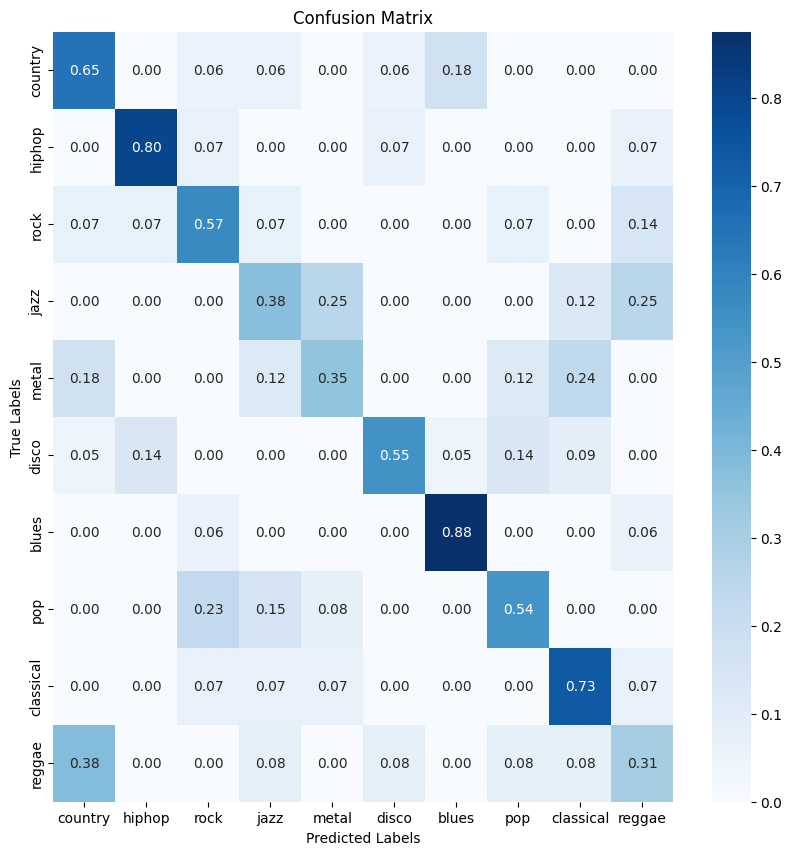

In [ ]:
plot_confusion_matrix(myModel, test_dl, device, classes)